# Transfer Learning for Defect Detection

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import os, sys
import copy


# plt.ion()   # interactive mode

In [2]:
print(sys.version)
print('torch.cuda.is_available() --> ', torch.cuda.is_available())
# print(torch.cuda.memory_summary())
print(torch.cuda.get_device_properties(0))

3.9.7 | packaged by conda-forge | (default, Sep 23 2021, 07:24:41) [MSC v.1916 64 bit (AMD64)]
torch.cuda.is_available() -->  True
_CudaDeviceProperties(name='GeForce GTX 1060', major=6, minor=1, total_memory=6144MB, multi_processor_count=10)


Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
img_size = 300
width, height = img_size, img_size
IMG_SIZE = (width, height)


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# data_dir = 'D:/Téléchargements/Datasets/hymenoptera_data/hymenoptera_data/'
data_dir = 'D:/Téléchargements/Datasets/casting-defect/casting_data/casting_data/'


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images<br>
Let's visualize a few training images so as to understand the data
augmentations.



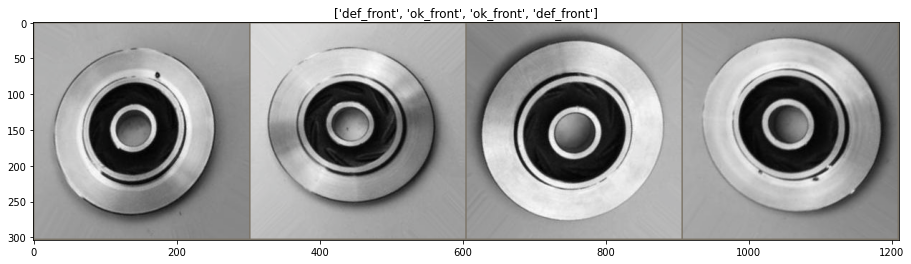

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
plt.figure(figsize=(16, 4))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=5):
    was_training = model.training
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(4*num_images, 5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.subplot(1, num_images, images_so_far)
                plt.axis('off')
                plt.title('predicted: {}'.format(class_names[preds[j]]))
                im = inputs.cpu().detach().data[j].numpy().transpose((2, 1, 0))
                im = (im - im.min()) / (im.max() - im.min())
                plt.imshow(im)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
        

Transfer-learning
----------------------
Load a pretrained model and reset final fully connected layer.<br>
Train that new classification head while freezing all pre-trained layers.




In [7]:
# load pre-trained backbone 
model_ft = models.vgg16(pretrained=True)

# replace classification head
num_ftrs = model_ft.classifier[6].in_features 
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names), bias=True)

# use cuda if available
model_ft = model_ft.to(device)

# choose loss function
criterion = nn.CrossEntropyLoss()

# freeze all layers except the new one
for param in model_ft.parameters():
    param.requires_grad = False
for param in model_ft.classifier[6].parameters():
    param.requires_grad = True

# choose optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
# model summary
s = summary(model_ft, torch.ones((1, 3, img_size, img_size)))

C:\Users\mehdi\Anaconda3\envs\pytorch_img_classif\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 9, 9]           --
|    └─Conv2d: 2-1                       [-1, 64, 300, 300]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 300, 300]        --
|    └─Conv2d: 2-3                       [-1, 64, 300, 300]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 300, 300]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 150, 150]        --
|    └─Conv2d: 2-6                       [-1, 128, 150, 150]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 150, 150]       --
|    └─Conv2d: 2-8                       [-1, 128, 150, 150]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 150, 150]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 75, 75]         --
|    └─Conv2d: 2-11                      [-1, 256, 75, 75]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 75,

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.6637 Acc: 0.7803
val Loss: 0.1434 Acc: 0.9483

Epoch 1/9
----------
train Loss: 0.5979 Acc: 0.8251
val Loss: 0.3189 Acc: 0.8657

Epoch 2/9
----------
train Loss: 0.6108 Acc: 0.8360
val Loss: 0.1911 Acc: 0.9231

Epoch 3/9
----------
train Loss: 0.5909 Acc: 0.8308
val Loss: 0.2330 Acc: 0.9021

Epoch 4/9
----------
train Loss: 0.5557 Acc: 0.8503
val Loss: 0.0979 Acc: 0.9650

Epoch 5/9
----------
train Loss: 0.5664 Acc: 0.8449
val Loss: 0.7323 Acc: 0.7552

Epoch 6/9
----------
train Loss: 0.6022 Acc: 0.8370
val Loss: 0.1398 Acc: 0.9413

Epoch 7/9
----------
train Loss: 0.4350 Acc: 0.8737
val Loss: 0.1002 Acc: 0.9580

Epoch 8/9
----------
train Loss: 0.3859 Acc: 0.8782
val Loss: 0.0866 Acc: 0.9678

Epoch 9/9
----------
train Loss: 0.3422 Acc: 0.8844
val Loss: 0.1143 Acc: 0.9580

Training complete in 34m 10s
Best val Acc: 0.967832


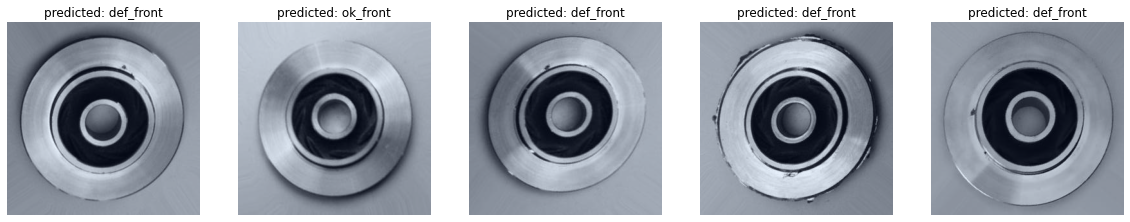

In [10]:
visualize_model(model_ft)

Fine-tuning
----------------------------------

Here, we will unfreze some of the modle layers (including pre-trained ones) and fine-tune them in order to improve the performance of the model.




In [11]:
model_ft.features[26:]

Sequential(
  (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): ReLU(inplace=True)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [12]:
for param in model_ft.parameters():
    param.requires_grad = False

features_finetune_from = 26
for param in model_ft.features[features_finetune_from:].parameters():
    param.requires_grad = True

for param in model_ft.classifier.parameters():
    param.requires_grad = False

summary(model_ft, torch.ones((1, 3, img_size, img_size)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 9, 9]           --
|    └─Conv2d: 2-1                       [-1, 64, 300, 300]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 300, 300]        --
|    └─Conv2d: 2-3                       [-1, 64, 300, 300]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 300, 300]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 150, 150]        --
|    └─Conv2d: 2-6                       [-1, 128, 150, 150]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 150, 150]       --
|    └─Conv2d: 2-8                       [-1, 128, 150, 150]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 150, 150]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 75, 75]         --
|    └─Conv2d: 2-11                      [-1, 256, 75, 75]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 75,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 9, 9]           --
|    └─Conv2d: 2-1                       [-1, 64, 300, 300]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 300, 300]        --
|    └─Conv2d: 2-3                       [-1, 64, 300, 300]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 300, 300]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 150, 150]        --
|    └─Conv2d: 2-6                       [-1, 128, 150, 150]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 150, 150]       --
|    └─Conv2d: 2-8                       [-1, 128, 150, 150]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 150, 150]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 75, 75]         --
|    └─Conv2d: 2-11                      [-1, 256, 75, 75]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 75,

In [13]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.75 every 2 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=2, gamma=0.75)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [14]:
model_ft = train_model(model_ft, criterion, optimizer_conv,  exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1227 Acc: 0.9593
val Loss: 0.0271 Acc: 0.9874

Epoch 1/4
----------
train Loss: 0.0422 Acc: 0.9867
val Loss: 0.0344 Acc: 0.9846

Epoch 2/4
----------
train Loss: 0.0251 Acc: 0.9931
val Loss: 0.0130 Acc: 0.9972

Epoch 3/4
----------
train Loss: 0.0248 Acc: 0.9926
val Loss: 0.0120 Acc: 0.9958

Epoch 4/4
----------
train Loss: 0.0188 Acc: 0.9947
val Loss: 0.0112 Acc: 0.9944

Training complete in 18m 17s
Best val Acc: 0.997203


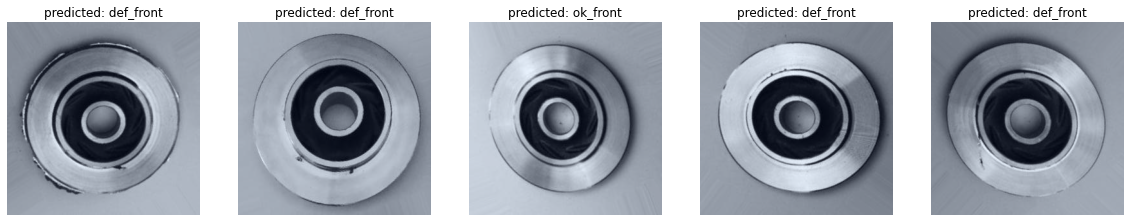

In [15]:
visualize_model(model_ft)

# plt.ioff()
plt.show()

Model Explainability
-----------------


In [18]:
from captum.attr import IntegratedGradients, GuidedGradCam, LayerGradCam, LayerDeepLift
# from captum.attr.visualization import visualize_image_attr
from torchvision.io import read_image
from PIL import Image
import cv2

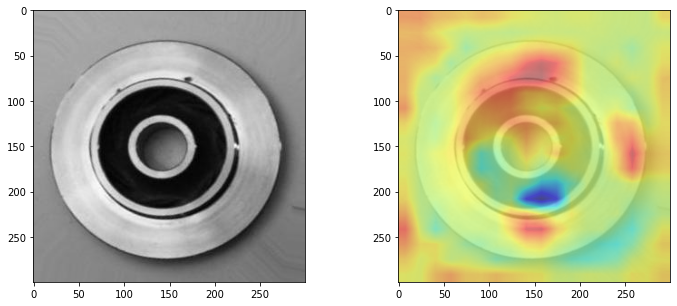

In [19]:
# ImageClassifier takes a single input tensor of images Nx3x32x32,
# and returns an Nx10 tensor of class probabilities.
# It contains an attribute conv4, which is an instance of nn.conv2d,
# and the output of this layer has dimensions Nx50x8x8.
# It is the last convolution layer, which is the recommended
# use case for GuidedGradCAM.
net = model_ft

# guided_gc = GuidedGradCam(net, net.features[22])
# guided_gc = LayerGradCam(net, net.features[27])

guided_gc = LayerGradCam(net, net.features[29])
# guided_gc = LayerDeepLift(net, net.features[29])


foldername = os.path.join(data_dir, 'val/' + class_names[0])
imagename = np.random.choice(os.listdir(foldername), 1)[0]

img = Image.open(os.path.join(foldername, imagename))
im = np.asarray(img)

img = data_transforms['val'](img)

input = img.reshape((1,)+img.shape)
input = input.to(device)
input.requires_grad = True


# Computes guided GradCAM attributions for class 3.
# attribution size matches input size, Nx3x32x32
attribution = guided_gc.attribute(input, target=0)


grid = attribution.cpu().detach().numpy()[0,:,:,:].transpose((1,2,0))
grid = 255 * ( (grid -  grid.min()) / (grid.max() -  grid.min()) )
grid = grid.astype(np.uint8)
grid = cv2.resize(grid, (300, 300), interpolation=cv2.INTER_LINEAR)

plt.figure(figsize=(12, 5))

plt.subplot(1,2,1)
plt.imshow(im)

plt.subplot(1,2,2)
plt.imshow(im, alpha=0.5)
plt.imshow(grid, alpha=0.5, cmap='jet')
plt.show()

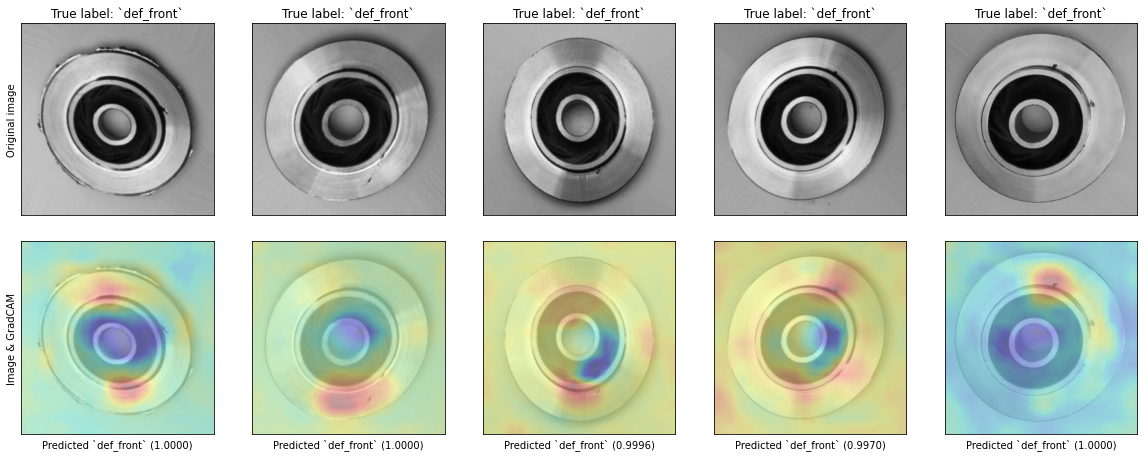

In [20]:
# choose neural net for which we'll compute interpretability heatmaps
net = model_ft

# choose an interpretability mmethod
guided_gc = LayerGradCam(net, net.features[29])

# set a number of images 
n_imgs = 5

# choose folder / subset
foldername = os.path.join(data_dir, 'val/' + class_names[0])

# choose images randomly
imagenames = np.random.choice(os.listdir(foldername), size=n_imgs, replace=False)

# open figure
plt.figure(figsize=(20, 10))

# iterate over images
for i, imagename in enumerate(imagenames):
    
    # load image
    img = Image.open(os.path.join(foldername, imagename))
    im = np.asarray(img)
    
    # transform & reshape image
    img = data_transforms['val'](img)
    input = img.reshape((1,)+img.shape)
    
    # send to cuda and track gradient
    input = input.to(device)
    input.requires_grad = True

    # Computes guided GradCAM attributions for class 
    attribution = guided_gc.attribute(input, target=0)

    # post-process GradCAM heatmap
    grid = attribution.cpu().detach().numpy()[0,:,:,:].transpose((1,2,0))
    grid = 255 * ( (grid -  grid.min()) / (grid.max() -  grid.min()) )
    grid = grid.astype(np.uint8)
    grid = cv2.resize(grid, (300, 300), interpolation=cv2.INTER_LINEAR)
    
    # retrieve confidence index
    outputs = model_ft(input)
    preds = nn.Softmax(dim=1)(outputs)
    preds = preds.cpu().detach().numpy()

    # plot original image
    plt.subplot(2, n_imgs, n_imgs*0 +i +1)
    plt.imshow(im)
    if i==0:
        plt.ylabel('Original image')
    ax = plt.gca()
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.title('True label: `{}`'.format(class_names[0]))
    
    # plot image with heatmap
    plt.subplot(2, n_imgs, n_imgs*1 +i +1)
    plt.imshow(im, alpha=0.5)
    plt.imshow(grid, alpha=0.30, cmap='jet')
    if i==0:
        plt.ylabel('Image & GradCAM')
    ax = plt.gca()    
    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.xlabel('Predicted `{}` ({:.4f})'.format(class_names[np.argmax(preds)], preds.max()))

plt.subplots_adjust(hspace=0.1, bottom=0.3)
plt.savefig('GradCAM_example.png')
plt.show()